<h2>LSTMs para la predicción de casos de Dengue en las ciudades de Iquitos y San Juan.</h2>

Autores: Pablo León Alcaide y Marcos Ludeña Triviño

<p>0. Preparación del entorno</p>

<p>0.1. Importaciones de módulos.</p>

In [1]:
import os

import itertools

import pandas as pd
import numpy as np
import random as rn
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.preprocessing import Imputer, LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from keras import backend as K
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM, Flatten
from keras.optimizers import Adam, RMSprop
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras import regularizers

Using TensorFlow backend.


<p>0.2. La función reset_env permitirá hacer los experimentos (y este kernel) reproducible.<p>

In [2]:
def reset_env():
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(42)
    rn.seed(12345)
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    tf.set_random_seed(1234)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)
    
reset_env()

sns.set(rc={'figure.figsize':(12,4)});
plt.figure(figsize=(12,4));

<p>1. Preparación de los datos.

1.1. Carga de los datos.<p>

In [3]:
train = pd.read_csv('./data/train.csv')
labels = pd.read_csv('./data/labels.csv')

test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/submission.csv')

train = train.merge(labels, on=['city', 'year', 'weekofyear'], how='left')
train.head()

city  year  weekofyear week_start_date   ndvi_ne   ndvi_nw   ndvi_se  \
0   sj  1990          18      1990-04-30  0.122600  0.103725  0.198483   
1   sj  1990          19      1990-05-07  0.169900  0.142175  0.162357   
2   sj  1990          20      1990-05-14  0.032250  0.172967  0.157200   
3   sj  1990          21      1990-05-21  0.128633  0.245067  0.227557   
4   sj  1990          22      1990-05-28  0.196200  0.262200  0.251200   

    ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k     ...       \
0  0.177617                 12.42             297.572857     ...        
1  0.155486                 22.82             298.211429     ...        
2  0.170843                 34.54             298.781429     ...        
3  0.235886                 15.36             298.987143     ...        
4  0.247340                  7.52             299.518571     ...        

   reanalysis_relative_humidity_percent  reanalysis_sat_precip_amt_mm  \
0                             73.365714                         12.42   
1                             77.368571                         22.82   
2                             82.052857                         34.54   
3                             80.337143                         15.36   
4                             80.460000                          7.52   

   reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
0                              14.012857           2.628571   
1                              15.372857           2.371429   
2                              16.848571           2.300000   
3                              16.672857           2.428571   
4                              17.210000           3.014286   

   station_avg_temp_c  station_diur_temp_rng_c  station_max_temp_c  \
0           25.442857                 6.900000                29.4   
1           26.714286                 6.371429                31.7   
2           26.714286                 6.485714                32.2   
3           27.471429                 6.771429                33.3   
4           28.942857                 9.371429                35.0   

   station_min_temp_c  station_precip_mm  total_cases  
0                20.0               16.0            4  
1                22.2                8.6            5  
2                22.8               41.4            4  
3                23.3                4.0            3  
4                23.9                5.8            6  

[5 rows x 25 columns]

<p>1.2. Dado que en la ciudad de Iquitos la mayoría de las semanas anteriores al año 2002 presentan 0 casos de dengue, se decide eliminarlos del dataset.<p>

In [4]:
train = train[(train.city == 'iq') & (train.year >= 2002) | (train.city == 'sj')].reset_index(drop=True)

<p>1.3. Los valores perdidos se calculan con la media de la caracteristica<p>

In [5]:
features_with_nulls = train.columns[train.isnull().sum() > 0].values

train_iq_mask = train.city == 'iq'
test_iq_mask = test.city == 'iq'
train_sj_mask = train.city == 'sj'
test_sj_mask = test.city == 'sj'


imputer = Imputer(strategy='mean')
imputer.fit(pd.concat([train.loc[train_iq_mask, features_with_nulls], 
                       test.loc[test_iq_mask, features_with_nulls]]))
train.loc[train_iq_mask, features_with_nulls] = imputer.transform(train.loc[train_iq_mask, features_with_nulls])
test.loc[test_iq_mask, features_with_nulls] = imputer.transform(test.loc[test_iq_mask, features_with_nulls])

imputer = Imputer(strategy='mean')
imputer.fit(pd.concat([train.loc[train_sj_mask, features_with_nulls], 
                       test.loc[test_sj_mask, features_with_nulls]]))
train.loc[train_sj_mask, features_with_nulls] = imputer.transform(train.loc[train_sj_mask, features_with_nulls])
test.loc[test_sj_mask, features_with_nulls] = imputer.transform(test.loc[test_sj_mask, features_with_nulls])

1.4. Se convierten las fechas a datatimes y se añade la característica del ems

In [6]:
train['week_start_date'] = pd.to_datetime(train.week_start_date)
test['week_start_date'] = pd.to_datetime(test.week_start_date)

train['month'] = train.week_start_date.dt.month
test['month'] = test.week_start_date.dt.month

<p>2. Una vez estan los datos preparados, se obtienen algunas gráficas.<p>

In [7]:
train_sj = train[train.city == 'sj']
train_iq = train[train.city == 'iq']

test_sj = test[test.city == 'sj']
test_iq = test[test.city == 'iq']

<p>2.1. En primer lugar se observa que la distribución del número de casos de dengue por semana en Iquitos y en San Juan es diferente. En San Juan hay más casos de dengue que en Iquitos habitualmente.<p>

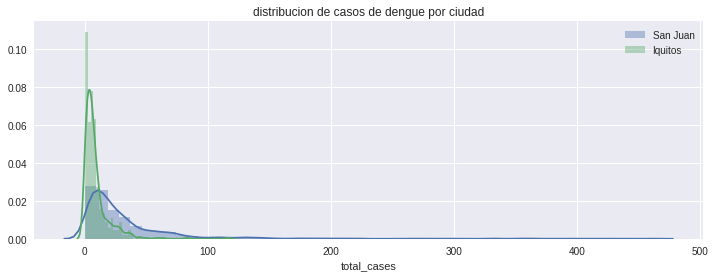

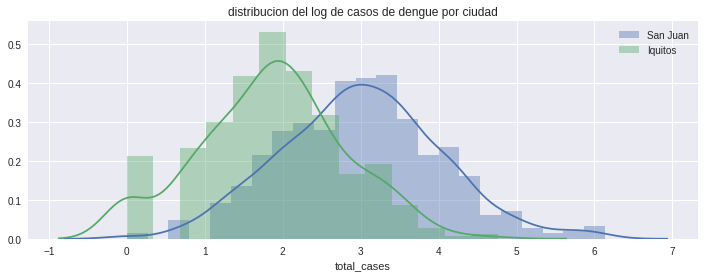

In [8]:
sns.distplot(train_sj.total_cases, label='San Juan')
sns.distplot(train_iq.total_cases, label='Iquitos')
plt.title('distribucion de casos de dengue por ciudad')
plt.legend()
plt.savefig('figures/casos_distribution.jpg', bbox_inches='tight')
plt.show()

sns.distplot(np.log1p(train_sj.total_cases), label='San Juan')
sns.distplot(np.log1p(train_iq.total_cases), label='Iquitos')
plt.title('distribucion del log de casos de dengue por ciudad')
plt.legend()
plt.savefig('figures/log-casos_distribution.jpg', bbox_inches='tight')
plt.show()

<p>2.2. Ahora se obsrvan la evolución temporal del número de casos de dengue por ciudad. En la ciudad de San Juan se observa un patrón periódico bastante claro, en el que en la parte final de cada año se obtienen máximos. Por otro lado, en la ciudad de Iquitos no se visualiza claramente ningún patrón secuencial. En ambas ciudades tampoco se observa que haya una tendencia de subida o bajada a lo largo de todos los años de los que se recogen datos.<p>

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2)

fig.set_size_inches((12, 7))

ax1.set_title('San Juan')
ax1.plot(train_sj.week_start_date.dt.date, train_sj.total_cases)

ax2.set_title('Iquitos')
ax2.plot(train_iq.week_start_date.dt.date, train_iq.total_cases)
plt.savefig('figures/series.jpg', bbox_inches='tight')
plt.show()

<p>2.3. Analizando el número de casos mensuales en cada ciudad se ve un patrón claro en San Juan, donde el mínimo de casos se dan en abril y mayo y el máxmimo en octubre. Por otro lado, en Iquitos, el numero de casos mínimo se da en junio y julio, y el máximo en febrero.<p>

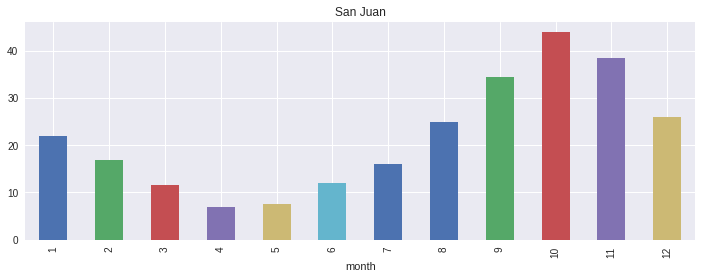

In [10]:
train_sj.groupby('month')['total_cases'].median().plot(kind='bar', title='San Juan')
plt.show()

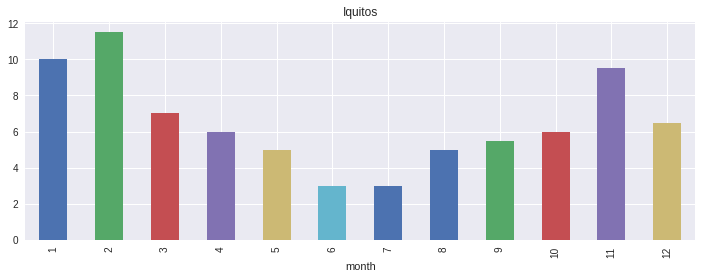

In [11]:
train_iq.groupby('month')['total_cases'].median().plot(kind='bar', title='Iquitos')
plt.show()

<p>3. Selección de conjunto de validación.</p>

<p>
3.1. En la competición se evalúan las predicciones para diferentes intervalos de tiempo en Iquitos y en San Juan. Para tratar de obtener unos valores de validación lo suficientemente relacionados con la puntuación que se pueda obtener, se decide seleccionar unos intervalos similares a los de test para validar los experimentos. Por tanto tenemos:</p>

<b>Iquitos</b>: 
<ul>
<li>Entrenamiento: semana 26 de 2002 a semana 25 de 2007</li>
<li>Validación: semana 26 de 2007 a semana 25 de 2007</li>
<li>Test Iquitos: semana 26 de 2010 a semana 26 de 2013</li>
</ul>

<b>San Juan</b>: 
<ul>
<li>Entrenamiento: semana 18 de 1990 a semana 17 de 2003</li>
<li>Validación: semana 18 de 2003 a semana 17 de 2008</li>
<li>Test: semana 18 de 2008 a semana 17 de 2013</li>
</ul>

In [12]:
valid_sj_mask = (train_sj.year > 2003) | ((train_sj.year == 2003) & (train_sj.weekofyear > 17))
valid_iq_mask = (train_iq.year > 2007) | ((train_iq.year == 2007) & (train_iq.weekofyear > 26))

<p>4. Preparación de los datos para usarlos en la red neuronal con LSTM

4.1. Eliminación de outliers.

In [13]:
train.loc[(train.city == 'sj') & (train.total_cases > 180), 'total_cases'] = 180
train.loc[(train.city == 'iq') & (train.total_cases > 60), 'total_cases'] = 60

4.2. Codificación one hot de las variables categóricas. En este el mes y la ciudad.

In [14]:
all_data = pd.concat([train, test]).reset_index(drop=True)

month_dummy = pd.get_dummies(all_data.month)
month_dummy.columns = ['month_' + str(x) for x in range(1, 13)]
all_data = pd.concat([all_data, month_dummy], axis=1)

In [15]:
city_encoder = LabelEncoder()
all_data['city'] = city_encoder.fit_transform(all_data.city)

all_data_dummy = pd.get_dummies(all_data.city)
all_data_dummy.columns = ['city1', 'city2']
all_data = pd.concat([all_data, all_data_dummy], axis=1)

4.3. Eliminación de columnas que no se usarán durante el entrenamiento.

In [16]:
all_data_y = all_data.total_cases
all_data_x = all_data.drop(['year', 'month', 'city', 'weekofyear', 'week_start_date', 'total_cases'], axis=1)

4.4. Escalado de las características numéricas y la variable objetivo entre -1 y 1 

In [17]:
f_scaler = MinMaxScaler(feature_range=(-1, 1))
all_data_x[:] = f_scaler.fit_transform(all_data_x[:])

y_scaler = MinMaxScaler(feature_range=(-1, 1))
train_only = ~all_data_y.isnull()
all_data_y[train_only] = y_scaler.fit_transform(all_data_y[train_only].values.reshape(-1, 1))

/home/pablo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


4.5. Preparación de los datos en series temporales. Se modela cada elemento del conjunto de entrenamiento en un tensor de dimensión (semanas, características). En el caso de este notebook se utiliza un valor de semanas=8, luego cada elemento consiste en la semana actual y las 7 semanas anteriores.

Se obtienen conjuntos de entrenamientom validación y test para cada ciudad y para ambas.

In [18]:
back_weeks = 8

def prepare_sequential_data(x, y, back_weeks):
    x_sequential = np.zeros((x.shape[0], back_weeks, x.shape[1]))
    y_sequential = np.zeros(x.shape[0])
    
    for idx in range(back_weeks, x.shape[0]):
        x_sequential[idx] = x[idx - back_weeks:idx]
        y_sequential[idx] = y[idx]
    
    return x_sequential, y_sequential
         

all_data_sj_x = all_data_x[all_data.city2 == 1].values
all_data_sj_y = all_data_y[all_data.city2 == 1].values

all_data_iq_x = all_data_x[all_data.city1 == 1].values
all_data_iq_y = all_data_y[all_data.city1 == 1].values

all_data_sj_seq_x, all_data_sj_seq_y = prepare_sequential_data(all_data_sj_x, all_data_sj_y, back_weeks)
all_data_iq_seq_x, all_data_iq_seq_y = prepare_sequential_data(all_data_iq_x, all_data_iq_y, back_weeks)

train_sj_mask = ~np.isnan(all_data_sj_y)
train_iq_mask = ~np.isnan(all_data_iq_y)

train_sj_seq_x = all_data_sj_seq_x[train_sj_mask]
train_sj_seq_y = all_data_sj_seq_y[train_sj_mask]

train_iq_seq_x = all_data_iq_seq_x[train_iq_mask]
train_iq_seq_y = all_data_iq_seq_y[train_iq_mask]

test_sj_seq_x = all_data_sj_seq_x[~train_sj_mask]
test_iq_seq_x = all_data_iq_seq_x[~train_iq_mask]

valid_sj_seq_x = train_sj_seq_x[valid_sj_mask.values]
valid_sj_seq_y = train_sj_seq_y[valid_sj_mask.values]

valid_iq_seq_x = train_iq_seq_x[valid_iq_mask.values]
valid_iq_seq_y = train_iq_seq_y[valid_iq_mask.values]

train_sj_seq_x = train_sj_seq_x[~valid_sj_mask.values]
train_sj_seq_y = train_sj_seq_y[~valid_sj_mask.values]

train_iq_seq_x = train_iq_seq_x[~valid_iq_mask.values]
train_iq_seq_y = train_iq_seq_y[~valid_iq_mask.values]

train_seq_x = np.concatenate([train_sj_seq_x, train_iq_seq_x], axis=0)
train_seq_y = np.concatenate([train_sj_seq_y, train_iq_seq_y])

valid_seq_x = np.concatenate([valid_sj_seq_x, valid_iq_seq_x], axis=0)
valid_seq_y = np.concatenate([valid_sj_seq_y, valid_iq_seq_y])

test_seq_x = np.concatenate([test_sj_seq_x, test_iq_seq_x], axis=0)

print('train[sj]: {0}'.format(train_sj_seq_x.shape))
print('valid[sj]: {0}\n'.format(valid_sj_seq_x.shape))
print('train[iq]: {0}'.format(train_iq_seq_x.shape))
print('valid[iq]: {0}\n'.format(valid_iq_seq_x.shape))
print('test[sj]: {0}'.format(test_sj_seq_x.shape))
print('test[iq]: {0}'.format(test_iq_seq_x.shape))

train[sj]: (676, 8, 34)
valid[sj]: (260, 8, 34)

train[iq]: (286, 8, 34)
valid[iq]: (156, 8, 34)

test[sj]: (260, 8, 34)
test[iq]: (156, 8, 34)


<p>5. Definición del modelo de red neuronal. Se usa la API funcional de la librería keras usando como backend tensorflow. Se optimiza el MSE y no el MAE, ya que los ajustes que se realizan en los parámetros optimizando el MAE son similares sea cual sea el error que se realice. Además, optimizar el MSE para entrenar una red neuronal es mucho más habitual.

In [19]:
def get_rnn_model(lstm_size=32, activation='relu', dropout=0.3, optimizer=Adam(lr=0.001, decay=0.0001)):    
    inputs = Input((back_weeks, train_seq_x.shape[2]))
    x = LSTM(lstm_size) (inputs)
    x = Dense(64, activation=activation) (x)
    x = Dropout(dropout) (x)
    x = Dense(32, activation=activation) (x)
    x = Dropout(dropout) (x)
    x = Dense(1, activation='linear') (x)
    
    model = Model(inputs=inputs, outputs=x)
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

<p>6. Búsqueda de parámetros.

In [20]:
resultados = pd.read_csv('resultados.csv')
resultados.loc[resultados.optimizer == 'rmsprop', 'optimizer'] = 1
resultados.loc[resultados.optimizer == 'adam', 'optimizer'] = 5
resultados.head()

back_weeks  batch_size   decay  dropout      lr  lstm_size        mae  \
0           8           8  0.0010      0.4  0.0010         24  17.264001   
1           8           8  0.0001      0.0  0.0010         24  14.615148   
2           8           8  0.0010      0.0  0.0005          8  16.440102   
3           8          32  0.0010      0.3  0.0010         24  18.830631   
4           8           8  0.0010      0.3  0.0010         24  16.291640   

          mse  optimizer  val_loss  
0  523.670586          1  0.055242  
1  478.335114          1  0.051956  
2  534.787487          5  0.061861  
3  561.732435          5  0.058472  
4  497.805661          5  0.054053

In [21]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Scatter, Figure, Layout, Parcoords
init_notebook_mode(connected=True)


data = [
    Parcoords(
        line = dict(color = 'blue'),
        dimensions = list([
            dict(range = [1, 5],
                 tickvals = [1, 5],
                 label = 'C', values = resultados.optimizer.values,
                 ticktext = ['rmsprop', 'adam']),
            dict(range=[resultados.batch_size.min(), resultados.batch_size.max()],
                 label = 'batch_size', 
                 values = resultados.batch_size.values),
            dict(range=[resultados.decay.min(), resultados.decay.max()],
                 label = 'decay', 
                 values = resultados.decay.values),
            dict(range=[resultados.dropout.min(), resultados.dropout.max()],
                 label = 'dropout', 
                 values = resultados.dropout.values),
            dict(range=[resultados.lr.min(), resultados.lr.max()],
                 label = 'lr', 
                 values = resultados.lr.values),
            dict(range=[resultados.lstm_size.min(), resultados.lstm_size.max()],
                 label = 'lstm_size', 
                 values = resultados.lstm_size.values),
            dict(range=[resultados.mae.min(), resultados.mae.max()],
                 label = 'mse', 
                 values = resultados.mae.values)
        ])
    )
]

iplot(data, filename = 'parcoord-dimensions')

In [22]:
resultados[resultados.val_loss == resultados.val_loss.min()]

back_weeks  batch_size   decay  dropout     lr  lstm_size        mae  \
21           8           8  0.0001      0.3  0.001         32  18.346186   

           mse  optimizer  val_loss  
21  567.780144          5  0.043478

6.2. Entrenamiento del modelo.

In [23]:
from keras.utils import plot_model

reset_env()
rnn_model = get_rnn_model()
plot_model(rnn_model, to_file='figures/model.png')
rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8, 34)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8576      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [24]:
rnn_model.fit(train_seq_x, train_seq_y, validation_data=(valid_seq_x, valid_seq_y), batch_size=8, epochs=34, 
              verbose=1, shuffle=True)

Train on 962 samples, validate on 416 samples
Epoch 1/34
962/962 [==============================] - 1s 1ms/step - loss: 0.1843 - val_loss: 0.1133
Epoch 2/34
962/962 [==============================] - 1s 801us/step - loss: 0.1393 - val_loss: 0.0803
Epoch 3/34
962/962 [==============================] - 1s 992us/step - loss: 0.1334 - val_loss: 0.0876
Epoch 4/34
962/962 [==============================] - 1s 822us/step - loss: 0.1222 - val_loss: 0.0621
Epoch 5/34
962/962 [==============================] - 1s 958us/step - loss: 0.1233 - val_loss: 0.0740
Epoch 6/34
962/962 [==============================] - 1s 890us/step - loss: 0.1205 - val_loss: 0.0979
Epoch 7/34
962/962 [==============================] - 1s 804us/step - loss: 0.1186 - val_loss: 0.1025
Epoch 8/34
962/962 [==============================] - 1s 769us/step - loss: 0.1147 - val_loss: 0.1138
Epoch 9/34
962/962 [==============================] - 1s 1ms/step - loss: 0.1200 - val_loss: 0.0879
Epoch 10/34
962/962 [===================

In [25]:
valid_pred = rnn_model.predict(valid_seq_x)

valid_pred = y_scaler.inverse_transform(valid_pred)
valid_y_ = y_scaler.inverse_transform(valid_seq_y.reshape(-1, 1))

mae = mean_absolute_error(valid_y_, valid_pred)
mse = mean_squared_error(valid_y_, valid_pred)
print('Expected MAE: {}'.format(mae))
print('Expected MSE: {}'.format(mse))

Expected MAE: 13.826069433
Expected MSE: 352.175244707


6.2. Se observan las predicciones y como se ajustan al conjunto de validación.

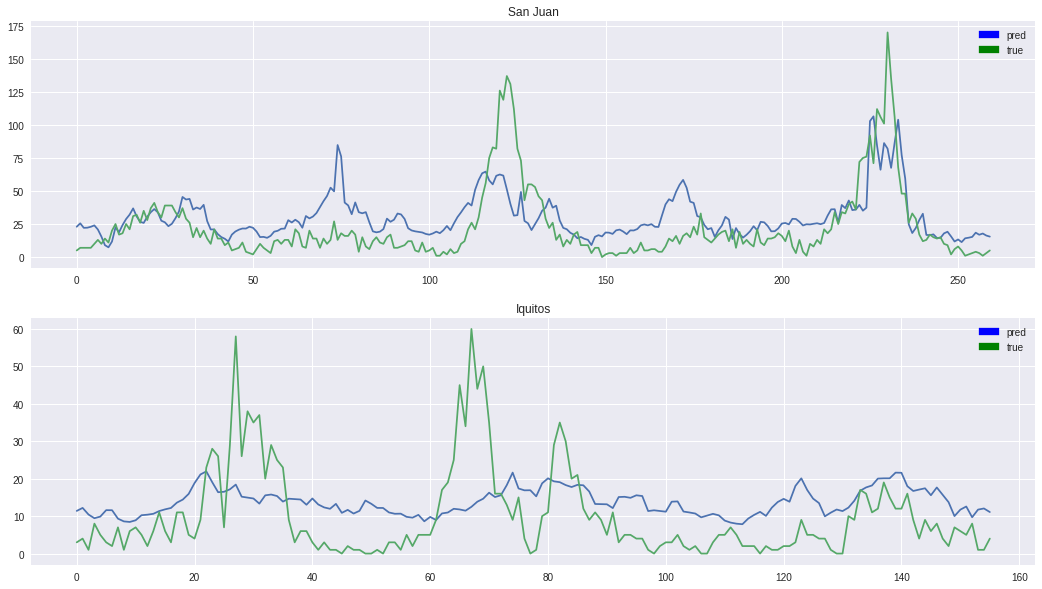

In [37]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches(18, 10)

blue_patch = mpatches.Patch(color='blue', label='pred')
green_patch = mpatches.Patch(color='green',label='true')

ax1.set_title('San Juan')
ax1.plot(valid_pred[:260])
ax1.plot(valid_y_[:260])
ax1.legend(handles=[blue_patch, green_patch])

ax2.set_title('Iquitos')
ax2.plot(valid_pred[260:])
ax2.plot(valid_y_[260:])
ax2.legend(handles=[blue_patch, green_patch])

plt.savefig('figures/preds.jpg', bbox_inches='tight')
plt.show()

6.3. Se entrena con todos los datos (entrenamiento y validación).

In [27]:
all_train_seq_x = np.vstack([train_seq_x, valid_seq_x])
all_train_seq_y = np.vstack([train_seq_y.reshape(-1, 1), valid_seq_y.reshape(-1, 1)])

rnn_model = get_rnn_model()
rnn_model.fit(all_train_seq_x, all_train_seq_y, batch_size=16, epochs=25, verbose=1)

Epoch 1/30
1378/1378 [==============================] - 1s 987us/step - loss: 0.1834
Epoch 2/30
1378/1378 [==============================] - 1s 504us/step - loss: 0.1176
Epoch 3/30
1378/1378 [==============================] - 1s 508us/step - loss: 0.1156
Epoch 4/30
1378/1378 [==============================] - 1s 507us/step - loss: 0.1100
Epoch 5/30
1378/1378 [==============================] - 1s 560us/step - loss: 0.1080
Epoch 6/30
1378/1378 [==============================] - 1s 499us/step - loss: 0.1060
Epoch 7/30
1378/1378 [==============================] - 1s 478us/step - loss: 0.1017
Epoch 8/30
1378/1378 [==============================] - 1s 470us/step - loss: 0.0992
Epoch 9/30
1378/1378 [==============================] - 1s 538us/step - loss: 0.0992
Epoch 10/30
1378/1378 [==============================] - 1s 548us/step - loss: 0.0983
Epoch 11/30
1378/1378 [==============================] - 1s 527us/step - loss: 0.0987
Epoch 12/30
1378/1378 [==============================] - 1s 474

7.3. Se muestran las distribuciones de las predicciones.

In [28]:
test_sj_y = rnn_model.predict(test_sj_seq_x)
test_iq_y = rnn_model.predict(test_iq_seq_x)

sns.distplot(test_sj_y)
sns.distplot(test_iq_y)
plt.show()

test_sj_y = y_scaler.inverse_transform(test_sj_y)
test_iq_y = y_scaler.inverse_transform(test_iq_y)

<p>8. Se preparan los resultados para subirlos y que sean evaluados en la competición.

In [29]:
submission.loc[submission.city=='sj', 'total_cases'] = np.clip(test_sj_y, 0, max(test_sj_y))
submission.loc[submission.city=='iq', 'total_cases'] = np.clip(test_iq_y, 0, max(test_iq_y))

submission['total_cases'] = submission.total_cases.astype(np.int32)
submission.to_csv('submissions/{}_lstm.csv'.format(round(mae, 4)), index=False)
submission.head()

city  year  weekofyear  total_cases
0   sj  2008          18            2
1   sj  2008          19            4
2   sj  2008          20            4
3   sj  2008          21            5
4   sj  2008          22            7

8.1. Distribución final de las predicciones una vez devueltas a la escala original.

In [30]:
sns.distplot(submission.total_cases)
plt.show()